## Assignment Description

Assignment Task for Data Scientists

Introduction

You are a Data Scientist working at upday, a news aggregator and recommender.

The engineering team at upday is gathering on a regular basis articles from all the Web. In order to provide a proper filtering functionality in the app, the articles need to be categorized.

You have at your disposal a pre-labelled dataset that maps different articles and their metadata to a specific category.

It's up to you now to help the company providing a solution for automatically categorizing articles.

Assignment

The repository contains a dataset with some english articles and some information about them:

category
title
text
url
The purpose of the task is to provide a classification model for the articles.

Instructions

You should make a pull request to this repository containing the solution. If you need to clarify any point of your solution, please include an explanation in the PR description.

What we expect:

Results from your data exploration and an explanation about the solution you adopted.
Documentation of the results of your model, including the choice of model(s), metrics adopted and the final evaluation.
The training and evaluation code, ideally as separate scripts.
The solution should just perform better than random, also we expect you to use a model that is not just rules-based.

How to present the documentation and the code is up to you, whether to provide python scripts, jupyter notebooks or via a different mean.

Bonus

Show off your engineering skills. What steps would you take to productionize the model?

We have listed some ideas below, but we would love to see the steps you would take.

Wrap your model into an API and document your instructions on how to test it
Or.. Create a Docker image (or surprise us!) that can be used to run your code
Or.. Include some unit tests in your training code

## Solution Description

Text, title and url columns have been used to extract features to be used for multilabel classification. 

There are 2 types of features created:

1. url related features where we add 1/0 columns corresponding to each category, 1 if words that consist this category exist in the url, 0 if not

2. text+title related features. Text and title columns have been concatenated, and the new title+text column has been processed to calculate top 300 tfidf features in regard to the category.

Model is a neural network classifier created with tensorflow functional api.

80% of data we used for training and 20% for testing, model accuracy is around 84% on test dataset which is better than random as requested from the assignment.

## Libraries Required

In [1]:
import pandas as pd
import numpy as np
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelBinarizer

SEED=4

## Data Overview

In [2]:
data = pd.read_csv('data_redacted.tsv',sep='\t')
data.head()

,title,text,url,category
0,"Don""t Mourn the Y Chromosome","The human Y chromosome may vanish one day, but...",http://discovermagazine.com/2014/nov/13-y-not,technology_science
1,Destiny: Bungie to introduce ammo pack micro-t...,Bungie is putting together plans to start sell...,http://www.ibtimes.co.uk/destiny-bungie-introd...,digital_life
2,Daruvala to race for Josef Kaufmann Racing in ...,Highly rated Jehan Daruvala will race for Jose...,http://www.thecheckeredflag.co.uk/2015/12/daru...,sports
3,Secondary tropical forests absorb carbon at hi...,Forests are an important carbon sink. While mo...,http://www.sciencedaily.com/releases/2016/02/1...,technology_science
4,This Brow Hack Will Change the Way You Fill In...,Before everyone was trying to get eyebrows on ...,http://www.popsugar.com/beauty/How-Use-Brow-Ge...,fashion_beauty_lifestyle


In [3]:
data.describe(include='all')

,title,text,url,category
count,8646,8646,8646,8646
unique,8639,8646,8646,12
top,The 10 things in advertising you need to know ...,"The human Y chromosome may vanish one day, but...",http://discovermagazine.com/2014/nov/13-y-not,fashion_beauty_lifestyle
freq,3,1,1,1398


There are title duplicates so we should consider using not only title for category prediction as we could have duplicates in the future as well

<AxesSubplot:>

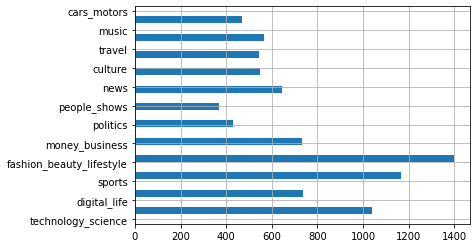

In [4]:
#As seen below, there are some categories which are more frequent than others
data['category'].hist(orientation='horizontal', bins=12, rwidth=0.4)

In [5]:
#the distribution of categories in percentages
data['category'].value_counts() / data.shape[0]

fashion_beauty_lifestyle    0.161693
sports                      0.134744
technology_science          0.120287
digital_life                0.085357
money_business              0.084779
news                        0.074717
music                       0.065695
culture                     0.063266
travel                      0.062919
cars_motors                 0.054360
politics                    0.049734
people_shows                0.042447
Name: category, dtype: float64

## Text processing

We will concatenate the title+train columns and will clean text and extract features from this new column

In [6]:
data['title_text'] = data['title'] + ' ' + data['text']

In [7]:
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def remove_special_chars(x):
    return re.sub(r"[^A-Za-z0-9]+", " ", x)

def remove_extra_spaces(x):
    return " ".join(x.split())

def remove_stopwords(text):
    words = text.split(' ')
    words = [w for w in words if w not in stop_words]
    return ' '.join(words)

def lower_text(x):
    return x.lower()

def lemmatize_words(text):
    words = text.split(' ')
    words = [lemmatizer.lemmatize(w) for w in words]
    return ' '.join(words)

def clean_text(x):
    x = remove_special_chars(x)
    x = remove_extra_spaces(x)
    x = lower_text(x)
    x = remove_stopwords(x)
    x = lemmatize_words(x)
    return x

In [8]:
data['title_text_clean'] = data.apply(lambda x: clean_text(x.title_text), axis=1)

## Create Features based on *url* column

In [9]:
def add_cat_flag_cols(data):
    "add 1/0 columns if category as word(s) is/are included in url or not"
    categories = list(data['category'].unique())
    categories = [(cat,cat.split('_')) for cat in categories]
    categories = {cat[0]:cat[1] for cat in categories}

    for cat in categories:        
        data[cat] = data['url'].str.contains('|'.join(categories[cat])).astype(int)
    
    return data

In [10]:
data = add_cat_flag_cols(data)

## Split Train Test Data

In [11]:
X_train, X_test = train_test_split(data, test_size=0.2, random_state=4, stratify=data['category'])

## Create & Select features

In [12]:
#Calculation of tfidf scores and selection of top 300 related to target column, in our case 'category'

tfidf = TfidfVectorizer(min_df=10, max_df=0.3, analyzer='word', max_features=3000)
title_text_clean_tfidf_scores = tfidf.fit_transform(X_train.title_text_clean)
selector = SelectKBest(f_classif, k=300)
title_text_clean_tfidf_topk = selector.fit_transform(title_text_clean_tfidf_scores, X_train['category'])

tfidf_topk_input = title_text_clean_tfidf_topk.toarray()

In [13]:
top_features = [int(x.replace('x','')) for x in selector.get_feature_names_out()]
top_features_names = tfidf.get_feature_names_out()[top_features]
print("words with best tfidf scores in relation to category:{}".format(top_features_names))

words with best tfidf scores in relation to category:['accommodation' 'actor' 'actress' 'adventure' 'ahead' 'aircraft' 'album'
 'android' 'app' 'apps' 'art' 'artist' 'athlete' 'audience' 'author'
 'authority' 'available' 'band' 'bass' 'beach' 'beat' 'bike' 'billion'
 'bmw' 'boat' 'book' 'brake' 'brexit' 'built' 'business' 'cabin' 'camera'
 'cameron' 'car' 'champion' 'championship' 'character' 'chemical' 'city'
 'club' 'coach' 'coast' 'company' 'composer' 'concert' 'conservative'
 'consumer' 'contemporary' 'country' 'crisis' 'cruise' 'cup' 'customer'
 'dance' 'data' 'debut' 'defeat' 'democratic' 'design' 'designed'
 'destination' 'developer' 'device' 'discovered' 'disease' 'dj' 'dr'
 'drama' 'drive' 'driving' 'drum' 'eat' 'eating' 'economic' 'economy'
 'education' 'election' 'electric' 'engine' 'england' 'eu' 'europe'
 'european' 'event' 'exhibition' 'explore' 'fan' 'feature' 'festival'
 'fight' 'film' 'final' 'financial' 'finish' 'finished' 'firm' 'flight'
 'food' 'foreign' 'former' 'f

In [14]:
#prepare input based on category flag columns for url
cat_cols = [cat for cat in X_train.columns if cat in set(X_train['category'])]
url_cat_input = np.array(X_train[cat_cols].values)

In [15]:
#create encodings for the categories available
cat_encoder = LabelBinarizer()
cat_encodings = cat_encoder.fit_transform(X_train['category'])

## Create & Train Model

In [16]:
tf.random.set_seed(SEED)

def create_model():
    """
    neural network with tensorflow functional api to concatenate values 
    from tfidf pipeline and url flag values    
    """
    tfidf_layer = tf.keras.layers.Input(shape=(300,))
    url_flag_layer = tf.keras.layers.Input(shape=(12,))   
    cc = tf.keras.layers.Concatenate()([tfidf_layer,url_flag_layer])
    cc_f = tf.keras.layers.Flatten()(cc)
    cc1 = tf.keras.layers.Dense(100, activation='relu')(cc_f)
    cc2 = tf.keras.layers.Dropout(0.2)(cc1)
    cc3 = tf.keras.layers.Dense(50, activation='relu')(cc2)
    output_layer = tf.keras.layers.Dense(12,activation="softmax")(cc3)
    model = tf.keras.Model(inputs=[tfidf_layer, url_flag_layer], outputs=output_layer)
    model.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                  optimizer=tf.keras.optimizers.Adam(),metrics="accuracy")
    return model

In [17]:
model = create_model()

2022-04-10 14:25:27.737803: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [18]:
#We use callback for early stopping so as to avoid overfitting
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=2)
model.fit([tfidf_topk_input, url_cat_input], cat_encodings, batch_size=20, epochs=20, validation_split=0.1,callbacks=[callback])

Epoch 1/20
312/312 [==============================] - 1s 1ms/step - loss: 1.6599 - accuracy: 0.5286 - val_loss: 0.9500 - val_accuracy: 0.7254
Epoch 2/20
312/312 [==============================] - 0s 1ms/step - loss: 0.7739 - accuracy: 0.7792 - val_loss: 0.6926 - val_accuracy: 0.7775
Epoch 3/20
312/312 [==============================] - 0s 1ms/step - loss: 0.6063 - accuracy: 0.8180 - val_loss: 0.6363 - val_accuracy: 0.8006
Epoch 4/20
312/312 [==============================] - 0s 1ms/step - loss: 0.5396 - accuracy: 0.8337 - val_loss: 0.6079 - val_accuracy: 0.8092
Epoch 5/20
312/312 [==============================] - 0s 1ms/step - loss: 0.4969 - accuracy: 0.8462 - val_loss: 0.6002 - val_accuracy: 0.8150
Epoch 6/20
312/312 [==============================] - 0s 1ms/step - loss: 0.4690 - accuracy: 0.8528 - val_loss: 0.5926 - val_accuracy: 0.8121
Epoch 7/20
312/312 [==============================] - 0s 1ms/step - loss: 0.4360 - accuracy: 0.8617 - val_loss: 0.5842 - val_accuracy: 0.8150
Epoch 

## Evaluate on Test Dataset

In [19]:
def evaluate_add_preds(model, data, tfidf, selector, cat_cols, cat_encoder):
    "evaluate on data and add predictions"
    title_text_clean_tfidf_scores = tfidf.transform(data.title_text_clean)
    title_text_clean_tfidf_topk = selector.transform(title_text_clean_tfidf_scores)
    
    tfidf_topk_input = title_text_clean_tfidf_topk.toarray()
    url_cat_input = np.array(data[cat_cols].values)
    cat_encodings = cat_encoder.transform(data['category'])
    
    model.evaluate([tfidf_topk_input, url_cat_input], cat_encodings)    
    
    preds = model.predict([tfidf_topk_input, url_cat_input])
    preds = [[preds[i].argmax(), preds[i][preds[i].argmax()]] for i in range(len(preds))]
    preds = [[cat_encoder.classes_[pred[0]],pred[1]] for pred in preds]
    
    X_test['category_pred'] = [pred[0] for pred in preds]
    X_test['pred_prob'] = [pred[1] for pred in preds]
    
    return X_test

In [20]:
X_test = evaluate_add_preds(model, X_test, tfidf, selector, cat_cols, cat_encoder)

55/55 [==============================] - 0s 726us/step - loss: 0.5430 - accuracy: 0.8393


## Conclusions

Accuracy of the model on test set is around 84% which is similar to what we would expect according to the train/validation results of the last epoch. Therefore the model seems to generalize well and works better than random. (Note that best result for a random model could be around 16% if we had a model which would predict always "fashion_beauty_lifestyle" category which is the most frequent in our dataset)

Crosstable below indicates the areas where we could work for improvement. In specific, there are several where category "fashion_beauty_lifestyle" is predicted falsely as "technology_science" and vice versa. In addition, there are cases where "news" category is falsely predicted as "politics". 

As next steps we could try to identify additional features which could help us seperate better these categories.

In [21]:
pd.crosstab(X_test['category'], X_test['category_pred'], rownames=['actual'], colnames=['predicted'])

predicted,cars_motors,culture,digital_life,fashion_beauty_lifestyle,money_business,music,news,people_shows,politics,sports,technology_science,travel
actual,,,,,,,,,,,,
cars_motors,87,1,2,1,2,0,0,0,1,0,0,0
culture,0,85,1,9,3,1,0,4,2,1,3,0
digital_life,4,2,126,3,4,0,4,1,0,0,2,2
fashion_beauty_lifestyle,3,7,5,231,2,0,5,6,1,1,14,5
money_business,2,2,9,9,116,0,0,1,2,1,4,1
music,0,1,0,0,0,108,2,3,0,0,0,0
news,5,2,2,9,3,0,80,1,18,0,7,2
people_shows,0,5,1,5,0,2,2,54,1,3,0,0
politics,0,0,0,0,6,0,8,0,68,0,4,0
